In [1]:
import pandas as pd
import numpy as np

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [24]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import RandomizedSearchCV

In [2]:
import ta
import talib
from tech_indicators import stoch,stoch_signal

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

## Preparing Data 


In [4]:
np.random.seed(999)

In [5]:
fcpo_data_daily=pd.read_hdf('processed_dta.h5','fcpo_data_daily')
fcpo_data_hourly=pd.read_hdf('processed_dta.h5','fcpo_data_hourly')

In [7]:
## TODO 
# normalise the high,low,open and close prices
# generate features based on signal crossovers and trend reversals
# generate pattern based features using TA-Lib (candlesticks etc)
# generate investment evaluation functions

In [6]:
def generate_tech_ind(fcpo_df):
    fcpo_df_tind=pd.DataFrame({
        'ema_slow':ta.trend.ema_slow(fcpo_df['Close'],n_slow=30).bfill(),
        'ema_fast':ta.trend.ema_fast(fcpo_df['Close'],n_fast=12).bfill(),
        'macd': ta.trend.macd(fcpo_df['Close']).bfill(),
        'macd_signal': ta.trend.macd_signal(fcpo_df['Close']).bfill(),
        'stoch' : stoch(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'stoch_signal' : stoch_signal(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'rsi':ta.momentum.rsi(fcpo_df['Close']).bfill(),
        'adx': ta.trend.adx(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'atr': ta.volatility.average_true_range(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close']).bfill(),
        'find' : ta.volume.force_index(fcpo_df['Close'],fcpo_df['Volume']).bfill(),
        'eom': ta.volume.ease_of_movement(fcpo_df['High'],fcpo_df['Low'],fcpo_df['Close'],fcpo_df['Volume'],n=10,fillna=True).bfill()
       })
    return fcpo_df_tind

In [7]:
fcpo_daily_tind=generate_tech_ind(fcpo_data_daily)

## Using Prophet for forecasting

In [10]:
#from fbprophet import Prophet
#prophet_model=Prophet()
#prophet_data_df=fcpo_data_daily['Close'].reset_index()
#prophet_data_df=prophet_data_df.rename(columns={'Date':'ds','Close':'y'})
#prophet_model.fit(prophet_data_df)

#prophet_forecast=prophet_model.make_future_dataframe(periods=365)
#prophet_forecast=prophet_model.predict(prophet_forecast)
#prophet_model.plot(prophet_forecast)

## Machine Learning models

In [8]:
def build_modeling_data(fcpo_data_daily,fcpo_daily_tind,target_label='lprofit_ind',split_date='2017-01-01'):
    fcpo_train=fcpo_daily_tind[:split_date]
    fcpo_test = fcpo_daily_tind[split_date:]

    fcpo_train=fcpo_train.merge(fcpo_data_daily[['Open','next_open_change_pct',target_label]],left_index=True,right_index=True)
    fcpo_traindata=fcpo_train.iloc[:,1:-1]
    fcpo_trainlabels=fcpo_train.iloc[:,-1:]
    
    fcpo_test=fcpo_test.merge(fcpo_data_daily[['Open','next_open_change_pct',target_label]],left_index=True,right_index=True)
    fcpo_testdata=fcpo_test.iloc[:,1:-1]
    fcpo_testlabels=fcpo_test.iloc[:,-1]
    return fcpo_traindata,fcpo_trainlabels,fcpo_testdata,fcpo_testlabels

### Long call trading model 

In [48]:
fcpo_lprofit_traindata,fcpo_lprofit_trainlabels,fcpo_lprofit_testdata,fcpo_lprofit_testlabels=build_modeling_data(fcpo_data_daily,
                                                                                                fcpo_daily_tind,'lprofit_ind','2016-01-01')

### Time-series cross validation

In [11]:
fcpo_tsplit=TimeSeriesSplit(n_splits=5)

In [61]:
### Compute cross-validation scores using time-series splits for a defined configuration ###
#rf_lprofit= RandomForestClassifier(n_estimators=200,max_depth=12,min_samples_split=4,
#                                  min_samples_leaf=3)

#rf_lprofit_cval_scores=cross_val_score(rf_lprofit,fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels),
#                                       scoring='roc_auc',cv=fcpo_tsplit)

In [82]:
## Use the RandomSearch funciton to find the best hyper parameters of Random forrests
rf_lprofit=RandomForestClassifier()

rf_param_dist = {"n_estimators" : [50,100,200,500],
              "max_depth": [3, 10,15],
              "max_features": [5,10,12],
              "min_samples_split": [2,4,8],
              "min_samples_leaf": [1,3,5],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

rf_lprofit_rsearch=RandomizedSearchCV(rf_lprofit,rf_param_dist,cv=fcpo_tsplit,scoring='roc_auc',
                                      n_iter=25,n_jobs=3)

In [83]:
%%time
rf_lprofit_rsearch.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

CPU times: user 2.35 s, sys: 77.6 ms, total: 2.43 s
Wall time: 56.3 s


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
          error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=3,
          param_distributions={'n_estimators': [50, 100, 200, 500], 'max_depth': [3, 10, 15], 'max_features': [5, 10, 12], 'min_samples_split': [2, 4, 8], 'min_samples_leaf': [1, 3, 5], 'bootstrap': [True, False], 'criterion': ['gini', 'entropy']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='precision', verbose=0)

In [80]:
rf_lprofit_rsearch.best_params_

{'n_estimators': 500,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_features': 12,
 'max_depth': 15,
 'criterion': 'entropy',
 'bootstrap': True}

In [85]:
rf_lprofit_rsearch.best_score_

0.6826393985934135

In [86]:
rf_lprofit_test_proba=rf_lprofit_rsearch.predict_proba(fcpo_lprofit_testdata)
rf_lprofit_test_predlabels=rf_lprofit_rsearch.predict(fcpo_lprofit_testdata)

### Gradient Boosting

In [42]:
gbm_lprofit=GradientBoostingClassifier(n_estimators=150,max_depth=15,min_samples_leaf=3,
                                       min_samples_split=3,learning_rate=0.1)

gbm_lprofit_cval_scores=cross_val_score(gbm_lprofit,fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels),
                                       scoring='roc_auc',cv=fcpo_tsplit)

gbm_lprofit.fit(fcpo_lprofit_traindata,np.ravel(fcpo_lprofit_trainlabels))

gbm_lprofit_test_proba=gbm_lprofit.predict_proba(fcpo_lprofit_testdata)
gbm_lprofit_test_predlabels=gbm_lprofit.predict(fcpo_lprofit_testdata)

### Short call trading model 

In [17]:
fcpo_sprofit_traindata,fcpo_sprofit_trainlabels,fcpo_sprofit_testdata,fcpo_sprofit_testlabels=build_modeling_data(fcpo_data_daily,fcpo_daily_tind,'sprofit_ind','2016-01-01')

In [18]:
rf_sprofit= RandomForestClassifier(n_estimators=200,max_depth=12,min_samples_split=2,
                                  min_samples_leaf=2)
rf_sprofit.fit(fcpo_sprofit_traindata,np.ravel(fcpo_sprofit_trainlabels))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
rf_sprofit_test_proba=rf_sprofit.predict_proba(fcpo_sprofit_testdata)
rf_sprofit_test_predlabels=rf_sprofit.predict(fcpo_sprofit_testdata)

In [20]:
gbm_sprofit=GradientBoostingClassifier(n_estimators=150,max_depth=15,min_samples_leaf=3,
                                       min_samples_split=3,learning_rate=0.1)
gbm_sprofit.fit(fcpo_sprofit_traindata,np.ravel(fcpo_sprofit_trainlabels))

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=15,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=3, min_samples_split=3,
              min_weight_fraction_leaf=0.0, n_estimators=150,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [21]:
gbm_sprofit_test_proba=gbm_sprofit.predict_proba(fcpo_sprofit_testdata)
gbm_sprofit_test_predlabels=gbm_sprofit.predict(fcpo_sprofit_testdata)

## Evaluation of Models

### AUC and Confusion Matrix

In [87]:
roc_auc_score(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels)

0.6991033755274262

In [88]:
confusion_matrix(fcpo_lprofit_testlabels,rf_lprofit_test_predlabels)

array([[119,  49],
       [ 49, 109]])

In [45]:
roc_auc_score(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels)

0.6525768535262206

In [46]:
confusion_matrix(fcpo_lprofit_testlabels,gbm_lprofit_test_predlabels)

array([[114,  54],
       [ 59,  99]])

In [ ]:
roc_auc_score(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels)

In [27]:
confusion_matrix(fcpo_sprofit_testlabels,rf_sprofit_test_predlabels)

array([[116,  48],
       [ 46, 116]])

In [28]:
roc_auc_score(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels)

0.6839054501656128

In [29]:
confusion_matrix(fcpo_sprofit_testlabels,gbm_sprofit_test_predlabels)

array([[116,  48],
       [ 55, 107]])

## Financial Metrics

The final objective of this study is to improve the ROI, hence we are focused on creating a score-card to measure the investement metrics to select the final model,

- Total Returns
- Maximum Drawdown
- Number of Wins
- Number of Losses

**Calculation of Returns**

* When the sprofit_indicator is true, then return is (open_price - next_low_price) - (commission_price),
* Else when the sprofit_indicator is false, the model waits until the end of the day before selling it hence the return is (open_price - next_close_price) - (commission_price)


In [30]:
def calculate_short_returns(x,pred_field,commission_price,num_units):
    return_myr=0
    #when the prediction is zero, the model accumulates no returns
    if x[pred_field]==0:
        return_myr=0
    #when the model makes a prediction
    elif x[pred_field]==1:
        if x['sprofit_ind']==1:
        #when it is correct, sell it off when it reaches max x% profit zone
            return_myr=(min((x['Open']-x['next_1low']),(x['Open']-x['Open']*0.98))*num_units)-commission_price
        #when it went wrong, sell it off when it reaches x% loss or wait till it reaches eod
        elif x['sprofit_ind']==0:
            return_myr=(max((x['Open']-x['next_1close']),(x['Open']-x['Open']*1.02))*num_units)-commission_price
    return return_myr

def calculate_long_returns(x,pred_field,commission_price,num_units):
    return_myr=0
    #when the prediction is zero, the model accumulates no returns
    if x[pred_field]==0:
        return_myr=0
    #when the model makes a prediction
    elif x[pred_field]==1:
        #when it is correct, sell it off when it reaches max x% profit zone
        if x['lprofit_ind']==1:
            return_myr=(min((x['next_1high']-x['Open']),(x['Open']*1.02-x['Open']))*num_units)-commission_price
        #when it went wrong, sell it off when it reaches x% loss or wait till it reaches eod
        elif x['lprofit_ind']==0:
            return_myr=(max((x['next_1close']-x['Open']),(x['Open']*0.98-x['Open']))*num_units)-commission_price
    return return_myr

def max_drawdown(X):
    mdd = 0
    peak = X[0]
    mdd_peak=0
    mdd_x=0
    for x in X:
        if x > peak: 
            peak = x
        dd = (peak - x) / peak
        if dd > mdd:
            mdd = dd
            mdd_peak=peak
            mdd_x=x
    return mdd_peak,mdd_x,mdd 

In [71]:
fcpo_eval_df=fcpo_data_daily[['Open','next_1low','next_1high','next_1close','lprofit_ind','sprofit_ind']].merge(
    pd.DataFrame(rf_lprofit_test_predlabels,columns=['rf_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(gbm_lprofit_test_predlabels,columns=['gbm_lprofit_prediction'],index=fcpo_lprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(gbm_sprofit_test_predlabels,columns=['gbm_sprofit_prediction'],index=fcpo_sprofit_testlabels.index),
            left_index=True,right_index=True).merge(
    pd.DataFrame(rf_sprofit_test_predlabels,columns=['rf_sprofit_prediction'],index=fcpo_sprofit_testlabels.index),
            left_index=True,right_index=True)

In [72]:
fcpo_eval_df['sprofit_returns']=fcpo_eval_df.apply(lambda x: calculate_short_returns(x,'rf_sprofit_prediction',0,1),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_sprofit_returns=fcpo_eval_df['sprofit_returns'].cumsum())

In [73]:
fcpo_eval_df['lprofit_returns']=fcpo_eval_df.apply(lambda x: calculate_long_returns(x,'rf_lprofit_prediction',0,1),axis=1)
fcpo_eval_df=fcpo_eval_df.assign(cummulative_lprofit_returns=fcpo_eval_df['lprofit_returns'].cumsum())

In [74]:
fcpo_eval_df=fcpo_eval_df.assign(cummulative_lprofit_returns=fcpo_eval_df['cummulative_lprofit_returns']+2500,
            cummulative_sprofit_returns=fcpo_eval_df['cummulative_sprofit_returns']+2500)

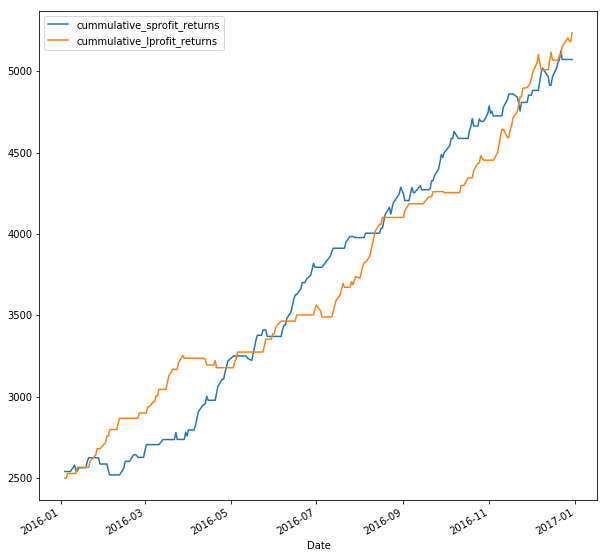

In [75]:
plt.figure(figsize=(10,10))
fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_sprofit_returns'].plot()
fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_lprofit_returns'].plot()
plt.legend()

In [76]:
max_drawdown(fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_lprofit_returns'])

(3253.2000000000007, 3177.7000000000007, 0.02320791835730972)

In [77]:
max_drawdown(fcpo_eval_df['2016-01-01':'2017-01-01']['cummulative_sprofit_returns'])

(2624.48, 2519.02, 0.04018319819545207)